# Simulation of a Multi-Server Queueing System with Jockeying (Banking Queue System)

This notebook simulates a banking queue system with **multiple tellers and jockeying** using the `simpy` library.

The simulation models customer arrivals, service times, queue dynamics, and **jockeying behavior** to analyze various performance metrics of the system.

## System Description

- **Multiple Tellers**: The bank has multiple tellers (servers), each with their own separate queue.
- **Customer Arrival**: Arriving customers join the **shortest queue**, choosing the **leftmost** shortest queue in case of ties.
- **Jockeying**: When a customer's service completes at teller $i$, if any other teller $j$ has $n_j > n_i + 1$ customers (where $n_i$ is the total number at teller $i$ including any in service), then the customer at the **tail** of queue $j$ moves to the **tail** of queue $i$.

## Assumptions

- **Interarrival times**: Exponentially distributed with mean **1 minute** ($\lambda = 1$ customer/minute)
- **Service times**: Exponentially distributed with mean **4.5 minutes** ($\mu = 1/4.5$ customers/minute)

## Objectives

We aim to measure and analyze the following performance metrics for systems with **4, 5, 6, and 7 tellers**:

1. **Average inter-arrival time $E[1/\lambda]$**: The average time between customer arrivals.
2. **Average service time $E[S]$**: The average time taken to serve a customer.
3. **Average delay time $E[D]$**: The average time customers spend waiting in the queue.
4. **Average number of customers in the system $E[N]$**: The average total number of customers.
5. **Server utilization rate $E[U]$**: The proportion of time the servers are busy.
6. **Jockeying statistics**: Number of jockeying events and their impact on performance.


In [11]:
from __future__ import annotations

import random
import statistics
from collections import defaultdict
from collections.abc import Generator, Iterable
from typing import Any, NoReturn, Optional

import matplotlib.pyplot as plt
import simpy
from simpy import Process
from simpy.events import Timeout
from simpy.resources.resource import Release, Request

In [12]:
class Customer:
    def __init__(
        self,
        env: simpy.Environment,
        bank: Bank,
        arrival_time: float,
        service_time: float,
    ) -> None:
        self.env = env
        self.bank = bank
        self.arrival_time: float = arrival_time
        self.service_time: float = service_time

        self.delay: float = 0
        self.departure_time: Optional[float] = None

        self.jovkeyed: bool = False
        self.current_teller: Optional[Teller] = None
        self.request: Optional[Request] = None
        self.served: bool = False

    @property
    def time_in_system(self) -> Optional[float]:
        """Total time spent in the system (waiting + service)"""
        if self.departure_time is not None:
            return self.departure_time - self.arrival_time
        return None

    def main(self) -> Generator[Request | Process, None]:
        self.current_teller = self.bank.get_shortest_queue()

        while not self.served:

            teller = self.current_teller
            teller.waiting_customers.append(self)

            queue_entry_time = self.env.now

            self.request = teller.request()
            yield self.request  # Wait for teller

            self.delay += self.env.now - queue_entry_time

            if not self.jovkeyed:  # Wasn't moved while waiting
                teller.waiting_customers.remove(self)

                yield self.env.process(teller.process_customer(self))

                self.departure_time = self.env.now
                teller.release(self.request)
                self.bank.check_jockeying(freed_teller=teller)
                self.served = True
            else:
                self.jovkeyed = False

    def cancel_request(self) -> None:
        if self.request is not None:
            self.request.cancel()


class Teller(simpy.Resource):
    def __init__(self, env: simpy.Environment, capacity: int) -> None:
        super().__init__(env, capacity)
        self.env = env
        self.queue_history: dict[int, float] = defaultdict(float)
        self.qt: list[tuple[float, int]] = []
        self.ut: list[tuple[float, int]] = [(0, 0)]

        self.last_queue_level: int = 0
        self.last_queue_level_timestamp: float = 0

        self.worked_time: float = 0

        self.waiting_customers: list[Customer] = []

    @property
    def average_queue_length(self) -> float:
        return (
            sum(
                queue_length * time for queue_length, time in self.queue_history.items()
            )
            / self.env.now
        )

    @property
    def utilization_rate(self) -> float:
        return self.worked_time / self.env.now

    def _update_qt(self) -> None:
        self.qt.append((self.env.now, len(self.queue)))

    def _update_ut(self) -> None:
        status = int(self.count == 1 or len(self.queue) > 0)
        if self.ut and self.ut[-1][1] == status:
            return
        self.ut.append((self.env.now, status))

    def _update_queue_history(self, _) -> None:
        self.queue_history[self.last_queue_level] += (
            self.env.now - self.last_queue_level_timestamp
        )
        self.last_queue_level_timestamp = self.env.now
        self.last_queue_level = len(self.queue)
        self._update_qt()

    def request(self) -> Request:
        request = super().request()
        self._update_queue_history(None)

        request.callbacks.append(self._update_queue_history)
        return request

    def release(self, request: Request) -> Release:
        release = super().release(request)
        self._update_ut()
        return release

    def process_customer(self, customer: Customer) -> Generator[Timeout, None, None]:
        yield self.env.timeout(customer.service_time)
        self.worked_time += customer.service_time

    def plot_qt(self, ax=None) -> None:
        if not self.qt:
            return
        x, y = zip(*self.qt)
        if ax is None:
            plt.step(x, y, where="pre")
            plt.fill_between(x, y, step="pre", alpha=1.0)
            plt.title("Q(t): Queue length over time")
            plt.xlabel("Simulation Time")
            plt.ylabel("Queue Length")
            plt.show()
        else:
            ax.step(x, y, where="pre")
            ax.fill_between(x, y, step="pre", alpha=0.5)

    def plot_ut(self, ax=None) -> None:
        ut = self.ut + [(self.env.now, self.ut[-1][1])]
        x, y = zip(*ut)
        if ax is None:
            plt.step(x, y, where="post")
            plt.fill_between(x, y, step="post", alpha=1.0)
            plt.title("U(t): Teller utilization over time")
            plt.xlabel("Simulation Time")
            plt.ylabel("Utilization rate")
            plt.show()
        else:
            ax.step(x, y, where="post")
            ax.fill_between(x, y, step="post", alpha=0.5)


class Bank:
    def __init__(
        self,
        env: simpy.Environment,
        num_tellers: int,
        customer_arrival_rate: float,
        customer_average_processing_time: float,
    ) -> None:
        self.env = env

        # M/M/c queueing system
        self.tellers = [Teller(env, capacity=1) for _ in range(num_tellers)]

        self.customer_arrival_rate = customer_arrival_rate
        self.customer_average_processing_time = customer_average_processing_time

        self.customers_inter_arrival_times: list[float] = []
        self.customers: list[Customer] = []

        self.jockeying_count: int = 0
        self.system_population: list[tuple[float, int]] = [(0, 0)]

    @property
    def customer_service_times(self) -> Iterable[float]:
        for customer in self.customers:
            yield customer.service_time

    @property
    def customer_delay_times(self) -> Iterable[float]:
        for customer in self.customers:
            if customer.served:
                yield customer.delay

    @property
    def customer_times_in_system(self) -> Iterable[float]:
        """Generator for time spent in system by each served customer"""
        for customer in self.customers:
            if customer.time_in_system is not None:
                yield customer.time_in_system

    @property
    def average_queue_length(self) -> float:
        """Average queue length across all tellers"""
        return sum(teller.average_queue_length for teller in self.tellers)

    @property
    def average_utilization_rate(self) -> float:
        """Average utilization rate across all tellers"""
        return statistics.fmean(teller.utilization_rate for teller in self.tellers)

    @property
    def average_customers_in_system(self) -> float:
        """Time-weighted average number of customers in the system using Little's Law: E[N] = λ * E[W]"""
        times_in_system = list(self.customer_times_in_system)
        if not times_in_system:
            return 0
        avg_time_in_system = statistics.fmean(times_in_system)
        # Little's Law: E[N] = λ * E[W]
        # λ = number of completed customers / total time
        throughput = len(times_in_system) / self.env.now
        return throughput * avg_time_in_system

    def _update_system_population(self, delta: int) -> None:
        """Update the system population tracking"""
        current_count = self.system_population[-1][1] if self.system_population else 0
        new_count = current_count + delta
        self.system_population.append((self.env.now, new_count))

    def get_shortest_queue(self) -> Teller:

        # return the teller with the shortest queue, or the leftmost one in case of a tie
        return min(self.tellers, key=lambda teller: len(teller.queue) + teller.count)

    def check_jockeying(self, freed_teller: Teller) -> None:
        n_i = len(freed_teller.queue) + freed_teller.count

        for other_teller in self.tellers:
            if other_teller is freed_teller:
                continue
            n_j = len(other_teller.queue) + other_teller.count
            if n_j > n_i + 1 and other_teller.waiting_customers:
                customer_to_jockey = other_teller.waiting_customers.pop(0)

                customer_to_jockey.jovkeyed = True
                customer_to_jockey.current_teller = freed_teller

                customer_to_jockey.cancel_request()

                other_teller._update_queue_history(None)
                self.jockeying_count += 1

                break

    def run(self) -> Generator[Timeout, Any, NoReturn]:
        while True:
            customer_inter_arrival_time = random.expovariate(
                lambd=self.customer_arrival_rate
            )
            self.customers_inter_arrival_times.append(customer_inter_arrival_time)

            customer_service_time = random.expovariate(
                1 / self.customer_average_processing_time
            )

            yield self.env.timeout(customer_inter_arrival_time)

            customer = Customer(
                env=self.env,
                bank=self,
                arrival_time=self.env.now,
                service_time=customer_service_time,
            )
            self.customers.append(customer)
            self._update_system_population(+1)

            self.env.process(self._customer_process(customer))

    def _customer_process(self, customer: Customer) -> Generator:
        """Wrapper to track customer departure"""
        yield self.env.process(customer.main())
        self._update_system_population(-1)

    @property
    def traffic_intensity(self) -> float:
        """Calculate traffic intensity ρ = λ / (c * μ)"""
        c = len(self.tellers)
        lam = self.customer_arrival_rate
        mu = 1 / self.customer_average_processing_time
        return lam / (c * mu)

    @property
    def is_stable(self) -> bool:
        """Check if the system is stable (ρ < 1)"""
        return self.traffic_intensity < 1

    def get_metrics(self) -> dict:
        """Get all performance metrics as a dictionary"""
        delay_times = list(self.customer_delay_times)
        service_times = list(self.customer_service_times)
        times_in_system = list(self.customer_times_in_system)

        return {
            "num_tellers": len(self.tellers),
            "num_customers": len(self.customers),
            "num_served": len(times_in_system),
            "traffic_intensity": self.traffic_intensity,
            "is_stable": self.is_stable,
            "avg_inter_arrival_time": (
                statistics.fmean(self.customers_inter_arrival_times)
                if self.customers_inter_arrival_times
                else 0
            ),
            "avg_service_time": statistics.fmean(service_times) if service_times else 0,
            "avg_delay_time": statistics.fmean(delay_times) if delay_times else 0,
            "avg_time_in_system": (
                statistics.fmean(times_in_system) if times_in_system else 0
            ),
            "avg_customers_in_system": self.average_customers_in_system,
            "avg_queue_length": self.average_queue_length,
            "avg_utilization_rate": self.average_utilization_rate,
            "jockeying_count": self.jockeying_count,
            "jockeying_rate": (
                self.jockeying_count / len(self.customers) if self.customers else 0
            ),
        }

    def plot_all_tellers_qt(self) -> None:
        """Plot queue length over time for all tellers"""
        fig, axes = plt.subplots(
            1, len(self.tellers), figsize=(4 * len(self.tellers), 3)
        )
        if len(self.tellers) == 1:
            axes = [axes]
        for i, (ax, teller) in enumerate(zip(axes, self.tellers)):
            teller.plot_qt(ax)
            ax.set_title(f"Teller {i+1} Q(t)")
            ax.set_xlabel("Time")
            ax.set_ylabel("Queue Length")
        plt.tight_layout()
        plt.show()

    def plot_all_tellers_ut(self) -> None:
        """Plot utilization over time for all tellers"""
        fig, axes = plt.subplots(
            1, len(self.tellers), figsize=(4 * len(self.tellers), 3)
        )
        if len(self.tellers) == 1:
            axes = [axes]
        for i, (ax, teller) in enumerate(zip(axes, self.tellers)):
            teller.plot_ut(ax)
            ax.set_title(f"Teller {i+1} U(t)")
            ax.set_xlabel("Time")
            ax.set_ylabel("Utilization")
        plt.tight_layout()
        plt.show()

    def plot_system_population(self) -> None:
        """Plot number of customers in system over time"""
        if len(self.system_population) < 2:
            print("Not enough data to plot")
            return
        x, y = zip(*self.system_population)
        plt.figure(figsize=(10, 4))
        plt.step(x, y, where="post")
        plt.fill_between(x, y, step="post", alpha=0.3)
        plt.title("N(t): Number of customers in system over time")
        plt.xlabel("Simulation Time (minutes)")
        plt.ylabel("Number of Customers")
        plt.show()

In [13]:
seed = 42
random.seed(seed)

env = simpy.Environment()
bank = Bank(
    env,
    num_tellers=5,
    customer_arrival_rate=1,
    customer_average_processing_time=4.5,
)
env.process(bank.run())
env.run(until=60 * 24 * 10)  # 10 days in minutes

## Average inter-arrival time E[1/λ]


Average Customer Inter-arrival time = 1.00 minutes


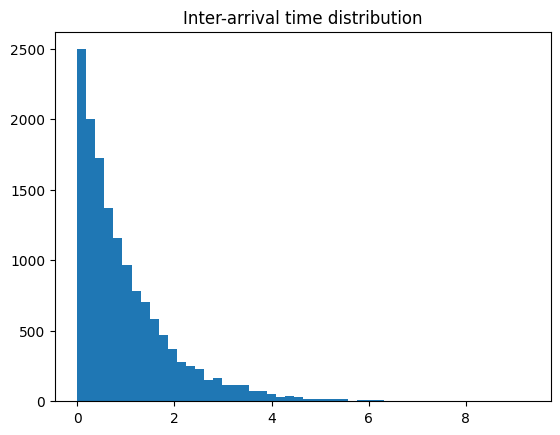

In [14]:
average_customer_inter_arrival_time = statistics.mean(
    bank.customers_inter_arrival_times
)
print(
    f"Average Customer Inter-arrival time = {average_customer_inter_arrival_time:.2f} minutes"
)
plt.hist(bank.customers_inter_arrival_times, bins=50)
plt.title("Inter-arrival time distribution")
plt.show()

## Average service time E[S]


Average Customer service time = 4.49 minutes


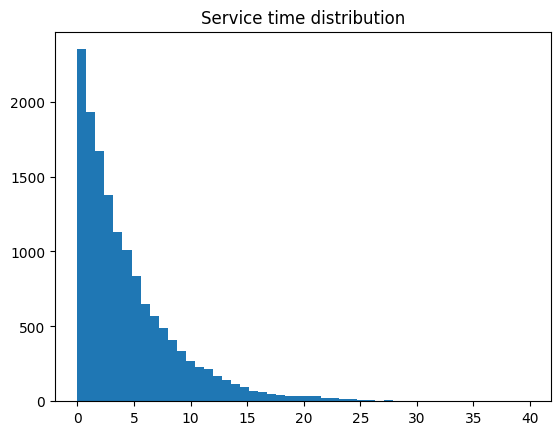

In [15]:
average_customer_service_time = statistics.mean(bank.customer_service_times)
print(f"Average Customer service time = {average_customer_service_time:.2f} minutes")
plt.hist(list(bank.customer_service_times), bins=50)
plt.title("Service time distribution")
plt.show()

## Average delay time E[D]


Average Customer delay time = 0.71 minutes


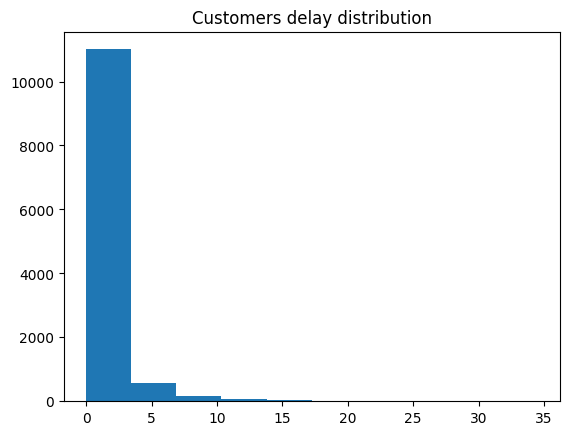

In [16]:
average_customer_delay_time = statistics.mean(bank.customer_delay_times)
print(f"Average Customer delay time = {average_customer_delay_time:.2f} minutes")
plt.hist(list(bank.customer_delay_times), bins=10)
plt.title("Customers delay distribution")
plt.show()

## Average number of customers in the queue E[Q] and in the system E[N]

Average total queue length (all tellers) = 1.00
  Teller 1 average queue length = 0.27
  Teller 2 average queue length = 0.25
  Teller 3 average queue length = 0.20
  Teller 4 average queue length = 0.16
  Teller 5 average queue length = 0.12


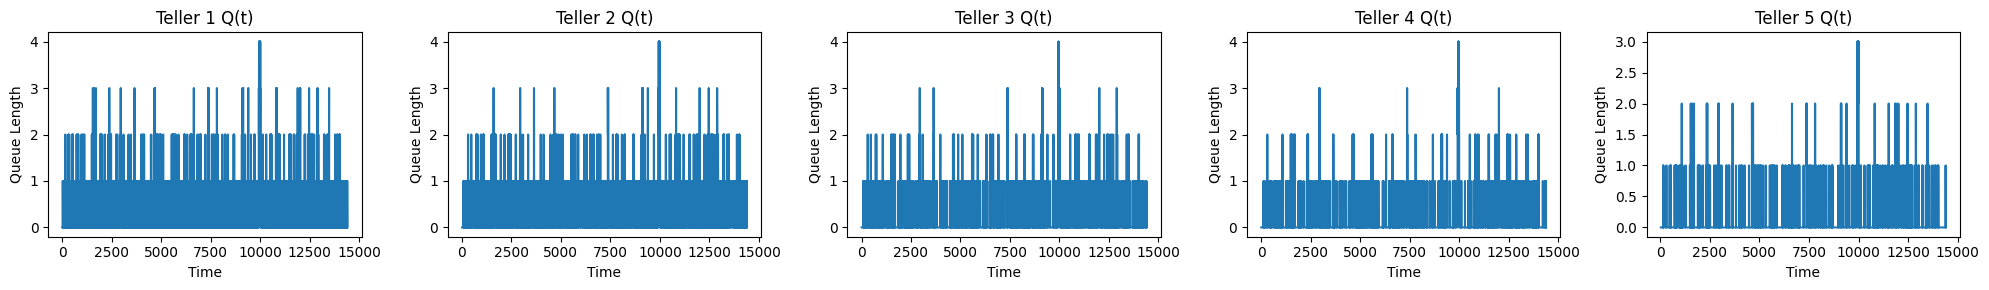

In [20]:
average_queue_length = bank.average_queue_length
print(f"Average total queue length (all tellers) = {average_queue_length:.2f}")
for i, teller in enumerate(bank.tellers):
    print(f"  Teller {i+1} average queue length = {teller.average_queue_length:.2f}")
bank.plot_all_tellers_qt()

Average number of customers in the system E[N] = 4.26


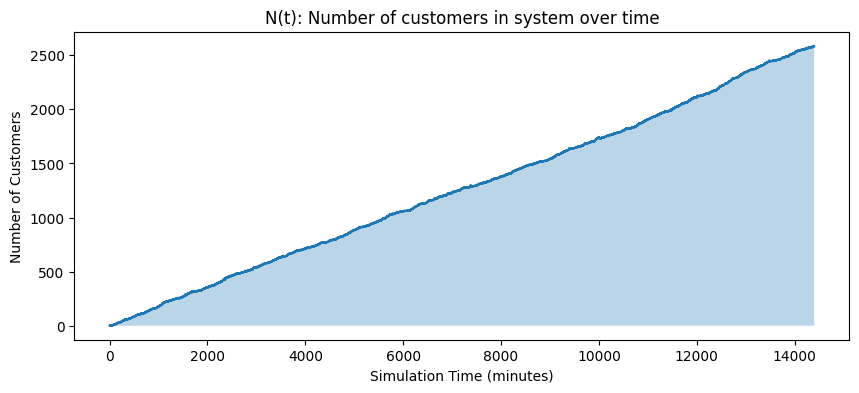

In [19]:
# Average number of customers in the system E[N]
avg_customers_in_system = bank.average_customers_in_system
print(f"Average number of customers in the system E[N] = {avg_customers_in_system:.2f}")
bank.plot_system_population()

## Server utilization rate E[U]


Average Server Utilization rate E[U] = 73.57%
  Teller 1 utilization rate = 86.42%
  Teller 2 utilization rate = 81.34%
  Teller 3 utilization rate = 74.76%
  Teller 4 utilization rate = 67.28%
  Teller 5 utilization rate = 58.07%


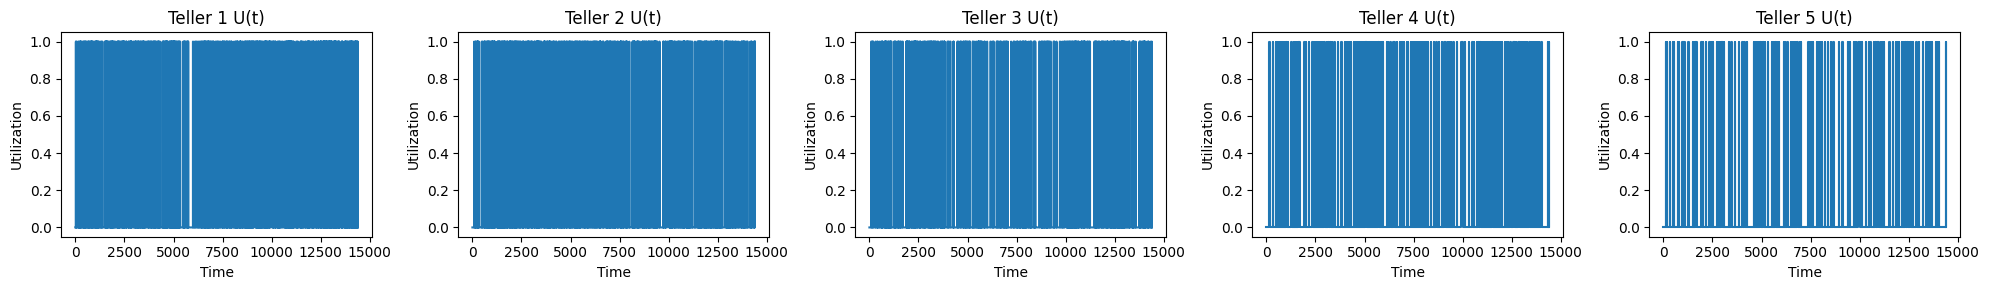

In [21]:
average_utilization_rate = bank.average_utilization_rate
print(f"Average Server Utilization rate E[U] = {average_utilization_rate * 100:.2f}%")
for i, teller in enumerate(bank.tellers):
    print(f"  Teller {i+1} utilization rate = {teller.utilization_rate * 100:.2f}%")
bank.plot_all_tellers_ut()

## Jockeying Statistics

In [22]:
print(f"Total jockeying events: {bank.jockeying_count}")
print(f"Jockeying rate: {bank.jockeying_count / len(bank.customers) * 100:.2f}% of customers jockeyed")

Total jockeying events: 2580
Jockeying rate: 17.84% of customers jockeyed


## Summary of All Metrics

In [23]:
# Display all metrics in a nice format
metrics = bank.get_metrics()
print("=" * 55)
print(f"SIMULATION SUMMARY ({metrics['num_tellers']} Tellers)")
print("=" * 55)
stability_status = "✅ STABLE" if metrics['is_stable'] else "❌ UNSTABLE"
print(f"System Status: {stability_status} (ρ = {metrics['traffic_intensity']:.4f})")
print(f"Total customers arrived: {metrics['num_customers']}")
print(f"Total customers served: {metrics['num_served']}")
print(f"\n--- Arrival & Service ---")
print(f"Average inter-arrival time E[1/λ]: {metrics['avg_inter_arrival_time']:.4f} minutes")
print(f"Average service time E[S]: {metrics['avg_service_time']:.4f} minutes")
print(f"\n--- Waiting & System Time ---")
print(f"Average delay time E[D]: {metrics['avg_delay_time']:.4f} minutes")
print(f"Average time in system E[W]: {metrics['avg_time_in_system']:.4f} minutes")
print(f"\n--- Queue & System Population ---")
print(f"Average queue length E[Q]: {metrics['avg_queue_length']:.4f}")
print(f"Average customers in system E[N]: {metrics['avg_customers_in_system']:.4f}")
print(f"\n--- Server Performance ---")
print(f"Average utilization rate E[U]: {metrics['avg_utilization_rate'] * 100:.2f}%")
print(f"\n--- Jockeying ---")
print(f"Total jockeying events: {metrics['jockeying_count']}")
print(f"Jockeying rate: {metrics['jockeying_rate'] * 100:.2f}%")

SIMULATION SUMMARY (5 Tellers)
System Status: ✅ STABLE (ρ = 0.9000)
Total customers arrived: 14458
Total customers served: 11876

--- Arrival & Service ---
Average inter-arrival time E[1/λ]: 0.9959 minutes
Average service time E[S]: 4.4852 minutes

--- Waiting & System Time ---
Average delay time E[D]: 0.7064 minutes
Average time in system E[W]: 5.1668 minutes

--- Queue & System Population ---
Average queue length E[Q]: 0.9957
Average customers in system E[N]: 4.2612

--- Server Performance ---
Average utilization rate E[U]: 73.57%

--- Jockeying ---
Total jockeying events: 2580
Jockeying rate: 17.84%


In [60]:
from tqdm import tqdm
import pandas as pd

def run_experiment(num_tellers: int, num_runs: int = 30, sim_duration: int = 60 * 24 * 10) -> list[dict]:
    """Run multiple simulations and collect metrics"""
    results = []
    for run in range(num_runs):
        random.seed(run)
        env = simpy.Environment()
        bank = Bank(
            env,
            num_tellers=num_tellers,
            customer_arrival_rate=1,  # 1 customer/minute
            customer_average_processing_time=4.5,  # 4.5 minutes mean service
        )
        env.process(bank.run())
        env.run(until=sim_duration)
        results.append(bank.get_metrics())
    return results

teller_configs = [4, 5, 6, 7]
all_results = {}

for num_tellers in tqdm(teller_configs, desc="Running experiments"):
    all_results[num_tellers] = run_experiment(num_tellers, num_runs=30)

Running experiments: 100%|██████████| 4/4 [00:32<00:00,  8.19s/it]


In [61]:
# Create a summary dataframe
summary_data = []
for num_tellers, results in all_results.items():
    df = pd.DataFrame(results)
    summary = {
        "num_tellers": num_tellers,
        "avg_inter_arrival": statistics.fmean(df["avg_inter_arrival_time"]),
        "avg_service_time": statistics.fmean(df["avg_service_time"]),
        "avg_delay_time": statistics.fmean(df["avg_delay_time"]),
        "avg_delay_time_std": statistics.stdev(df["avg_delay_time"]),
        "avg_time_in_system": statistics.fmean(df["avg_time_in_system"]),
        "avg_customers_in_system": statistics.fmean(df["avg_customers_in_system"]),
        "avg_queue_length": statistics.fmean(df["avg_queue_length"]),
        "avg_utilization": statistics.fmean(df["avg_utilization_rate"]),
        "avg_jockeying_count": statistics.fmean(df["jockeying_count"]),
        "avg_jockeying_rate": statistics.fmean(df["jockeying_rate"]),
    }
    summary_data.append(summary)

summary_df = pd.DataFrame(summary_data)
summary_df.set_index("num_tellers", inplace=True)
print("Summary Statistics by Number of Tellers:")
print(summary_df.round(4))

Summary Statistics by Number of Tellers:
             avg_inter_arrival  avg_service_time  avg_delay_time  \
num_tellers                                                        
4                       1.0003            4.4967          3.5344   
5                       1.0003            4.4967          0.7520   
6                       1.0003            4.4967          0.2086   
7                       1.0003            4.4967          0.0610   

             avg_delay_time_std  avg_time_in_system  avg_customers_in_system  \
num_tellers                                                                    
4                        0.5446              8.0223                   6.1122   
5                        0.0691              5.2445                   4.3033   
6                        0.0286              4.7045                   4.1253   
7                        0.0117              4.5564                   4.2088   

             avg_queue_length  avg_utilization  avg_jockeying_count  

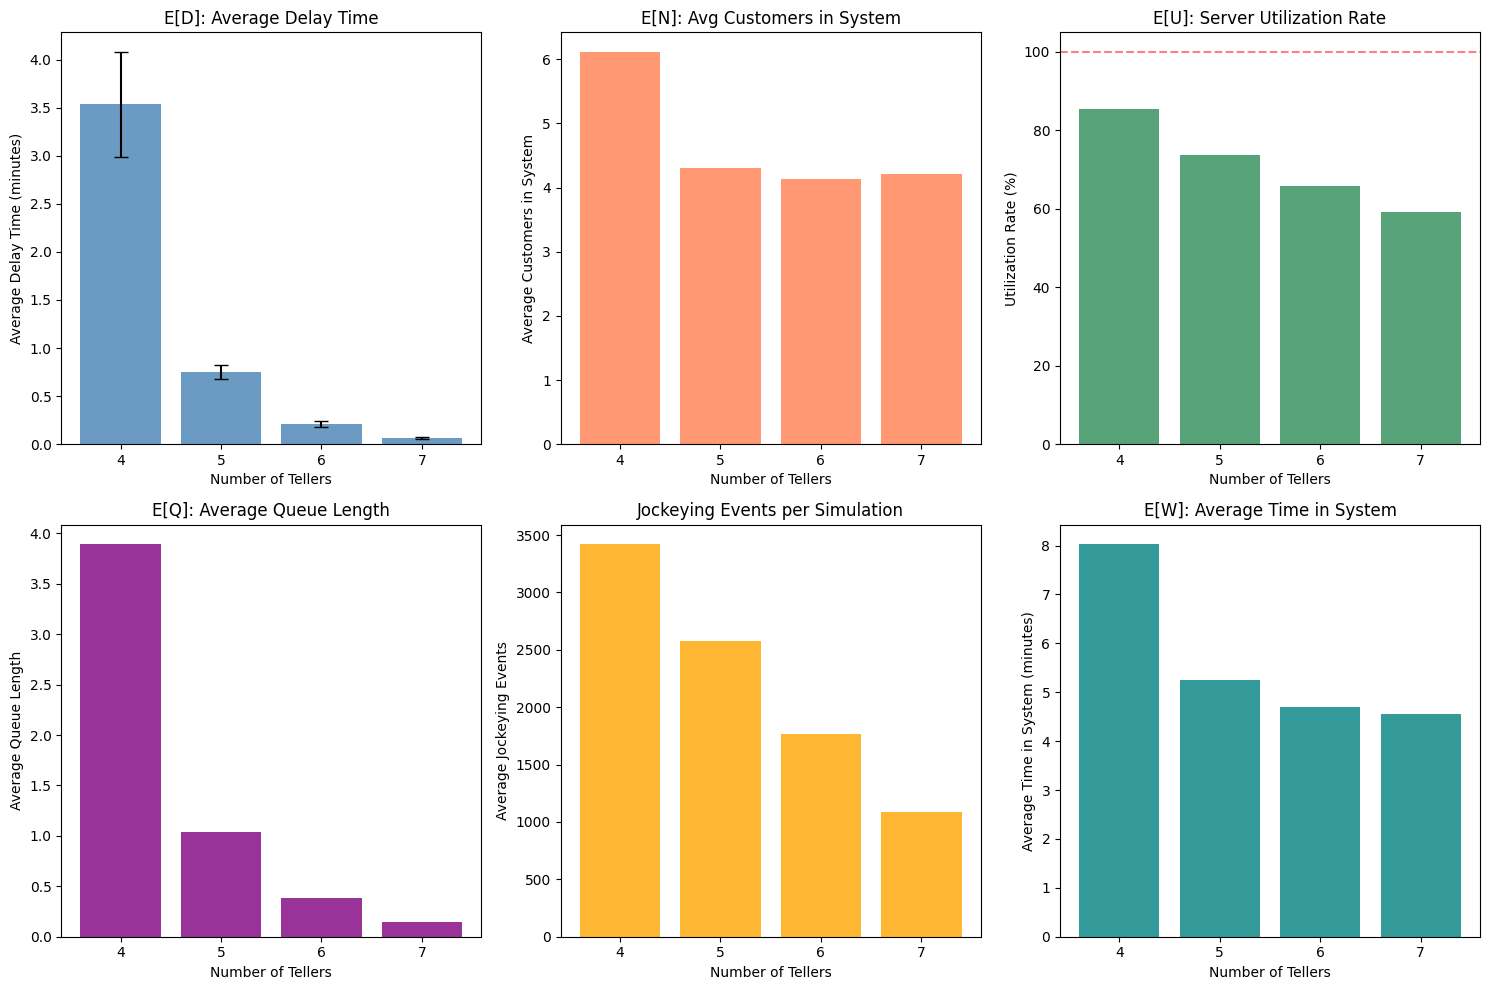

In [64]:
# Plot comparison charts
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Average Delay Time
ax = axes[0, 0]
x = summary_df.index
ax.bar(x, summary_df["avg_delay_time"], color='steelblue', alpha=0.8)
ax.errorbar(x, summary_df["avg_delay_time"], yerr=summary_df["avg_delay_time_std"], 
            fmt='none', color='black', capsize=5)
ax.set_xlabel("Number of Tellers")
ax.set_ylabel("Average Delay Time (minutes)")
ax.set_title("E[D]: Average Delay Time")
ax.set_xticks(x)

# 2. Average Customers in System
ax = axes[0, 1]
ax.bar(x, summary_df["avg_customers_in_system"], color='coral', alpha=0.8)
ax.set_xlabel("Number of Tellers")
ax.set_ylabel("Average Customers in System")
ax.set_title("E[N]: Avg Customers in System")
ax.set_xticks(x)

# 3. Server Utilization Rate
ax = axes[0, 2]
ax.bar(x, summary_df["avg_utilization"] * 100, color='seagreen', alpha=0.8)
ax.set_xlabel("Number of Tellers")
ax.set_ylabel("Utilization Rate (%)")
ax.set_title("E[U]: Server Utilization Rate")
ax.set_xticks(x)
ax.axhline(y=100, color='red', linestyle='--', alpha=0.5, label='100%')

# 4. Average Queue Length
ax = axes[1, 0]
ax.bar(x, summary_df["avg_queue_length"], color='purple', alpha=0.8)
ax.set_xlabel("Number of Tellers")
ax.set_ylabel("Average Queue Length")
ax.set_title("E[Q]: Average Queue Length")
ax.set_xticks(x)

# 5. Jockeying Events
ax = axes[1, 1]
ax.bar(x, summary_df["avg_jockeying_count"], color='orange', alpha=0.8)
ax.set_xlabel("Number of Tellers")
ax.set_ylabel("Average Jockeying Events")
ax.set_title("Jockeying Events per Simulation")
ax.set_xticks(x)

# 6. Time in System
ax = axes[1, 2]
ax.bar(x, summary_df["avg_time_in_system"], color='teal', alpha=0.8)
ax.set_xlabel("Number of Tellers")
ax.set_ylabel("Average Time in System (minutes)")
ax.set_title("E[W]: Average Time in System")
ax.set_xticks(x)

plt.tight_layout()
plt.show()

## Confidence Intervals (95%)

In [65]:
# Calculate 95% confidence intervals for key metrics
import scipy.stats as st

def confidence_interval(data, confidence=0.95):
    """Calculate confidence interval for the mean"""
    n = len(data)
    mean = statistics.mean(data)
    std_err = statistics.stdev(data) / (n ** 0.5)
    h = std_err * st.t.ppf((1 + confidence) / 2, n - 1)
    return mean, mean - h, mean + h

print("95% Confidence Intervals for Key Metrics")
print("=" * 70)

for num_tellers, results in all_results.items():
    print(f"\n{num_tellers} Tellers:")
    df = pd.DataFrame(results)
    
    # Delay time CI
    mean, lower, upper = confidence_interval(df["avg_delay_time"])
    print(f"  E[D] (Delay Time): {mean:.4f} minutes [{lower:.4f}, {upper:.4f}]")
    
    # Customers in system CI
    mean, lower, upper = confidence_interval(df["avg_customers_in_system"])
    print(f"  E[N] (Customers in System): {mean:.4f} [{lower:.4f}, {upper:.4f}]")
    
    # Utilization CI
    mean, lower, upper = confidence_interval(df["avg_utilization_rate"])
    print(f"  E[U] (Utilization): {mean*100:.2f}% [{lower*100:.2f}%, {upper*100:.2f}%]")

95% Confidence Intervals for Key Metrics

4 Tellers:
  E[D] (Delay Time): 3.5344 minutes [3.3311, 3.7378]
  E[N] (Customers in System): 6.1122 [5.9508, 6.2737]
  E[U] (Utilization): 85.48% [85.24%, 85.72%]

5 Tellers:
  E[D] (Delay Time): 0.7520 minutes [0.7262, 0.7778]
  E[N] (Customers in System): 4.3033 [4.2748, 4.3317]
  E[U] (Utilization): 73.72% [73.53%, 73.92%]

6 Tellers:
  E[D] (Delay Time): 0.2086 minutes [0.1979, 0.2193]
  E[N] (Customers in System): 4.1253 [4.1058, 4.1448]
  E[U] (Utilization): 65.71% [65.50%, 65.91%]

7 Tellers:
  E[D] (Delay Time): 0.0610 minutes [0.0566, 0.0654]
  E[N] (Customers in System): 4.2088 [4.1937, 4.2239]
  E[U] (Utilization): 59.32% [59.14%, 59.50%]
